# Bootstrap Resampling for Extreme Precipitation Analysis

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy import stats

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your dask-local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 or 20 nodes (10 or 20 dask workers)
cluster.scale(10)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46371 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/46371/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/46371/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:41114,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/46371/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read landfrac to subset land points

In [4]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
landfrac_file = 'landfrac_1deg_bil.nc'

In [5]:
landfrac = xr.open_dataarray(postprocessing_filepath+landfrac_file)

## Read and process extreme precipitation given input file and percentile

In [29]:
def process_PEx(path, file, landfrac, percentile):
    PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_1deg.shape[0] > 43800:
        PRECT_1deg = PRECT_1deg[:43800]
    
    # subset for land only (optional; comment out to use whole domain)
    PRECT_1deg = PRECT_1deg.where(landfrac > 0)
    
    # subset for CONUS only
    PRECT_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68))
    
    quantile = percentile/100
    
    # PEx by season
    pX_season = PRECT_CONUS.chunk({'time': -1}).groupby("time.season").quantile(quantile, dim='time')
    PEx_season = PRECT_CONUS.groupby("time.season").where(PRECT_CONUS.groupby("time.season") > pX_season)
    
    # select seasonal values
    PEx_DJF = PEx_season.sel(time=PEx_season.time.dt.season=="DJF")
    PEx_MAM = PEx_season.sel(time=PEx_season.time.dt.season=="MAM")
    PEx_JJA = PEx_season.sel(time=PEx_season.time.dt.season=="JJA")
    PEx_SON = PEx_season.sel(time=PEx_season.time.dt.season=="SON")
    
    return(PEx_DJF, PEx_MAM, PEx_JJA, PEx_SON)

#### Set percentile

In [13]:
percentile = 90

In [30]:
PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc' # bilinear interpolation, units are m/s
#PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_cons.nc' # conservative regridding
PEx_DJF, PEx_MAM, PEx_JJA, PEx_SON = process_PEx(postprocessing_filepath, PRECT_file, landfrac, percentile)

In [31]:
PRECT_file_rcp = 'PRECT_3hravg_NA_rcp85_1deg_bil.nc'
PEx_DJF_rcp, PEx_MAM_rcp, PEx_JJA_rcp, PEx_SON_rcp = process_PEx(postprocessing_filepath, PRECT_file_rcp, landfrac, percentile)

## Bootstrap resampling

### Create components for bootstrapping

In [20]:
def process_timeseries(P1, P2):

    # extreme precipitation for each simulation
    P_concat = xr.concat([P1, P2], dim='time')
    
    return(P_concat)

In [32]:
# seasonal timeseries
PEx_DJF_concat = process_timeseries(PEx_DJF, PEx_DJF_rcp)
PEx_MAM_concat = process_timeseries(PEx_MAM, PEx_MAM_rcp)
PEx_JJA_concat = process_timeseries(PEx_JJA, PEx_JJA_rcp)
PEx_SON_concat = process_timeseries(PEx_SON, PEx_SON_rcp)

In [33]:
# delete to reset memory
del PEx_DJF_concat_compute
del PEx_MAM_concat_compute
del PEx_JJA_concat_compute
del PEx_SON_concat_compute

In [34]:
%%time
# compute values to load into memory
PEx_DJF_concat_compute = PEx_DJF_concat.compute()

CPU times: user 10.2 s, sys: 791 ms, total: 11 s
Wall time: 32.9 s


In [35]:
%%time
# compute the rest of the seasons
PEx_MAM_concat_compute = PEx_MAM_concat.compute()
PEx_JJA_concat_compute = PEx_JJA_concat.compute()
PEx_SON_concat_compute = PEx_SON_concat.compute()

CPU times: user 29.7 s, sys: 2.12 s, total: 31.8 s
Wall time: 1min 34s


In [36]:
# calculate number of timesteps for each season
totalsize_DJF = PEx_DJF_concat.time.size
totalsize_MAM = PEx_MAM_concat.time.size
totalsize_JJA = PEx_JJA_concat.time.size
totalsize_SON = PEx_SON_concat.time.size

### DJF

In [46]:
%%time
# NOTE: load the concatenated arrays into memory first

#nsamps = 10
nsamps = 1000

# initialize a difference array
diffs_DJF = xr.zeros_like(PEx_DJF_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_DJF, size=int(totalsize_DJF/2), replace=True)
    # randomly sample the concatenated precip across hist/rcp
    boot_1 = PEx_DJF_concat_compute.isel(time=rand_index).sum(dim='time') 
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_DJF, size=int(totalsize_DJF/2), replace=True)
    boot_2 = PEx_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
       
    # final bootstrap sample is the percent difference between sums of each sample
    # does it matter which sample is used in the denominator here?
    diffs_DJF[ind,...] = 100*(boot_1 - boot_2)/boot_2
    
    # test first iteration of loop
    #break

CPU times: user 2min 54s, sys: 3min 19s, total: 6min 13s
Wall time: 8min 51s


In [47]:
diffs_DJF.shape

(1000, 25, 58)

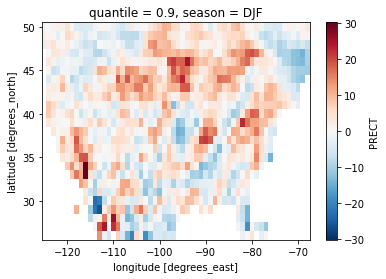

In [48]:
# distribution of values at first sample across space
diffs_DJF.isel(sample=0).plot();

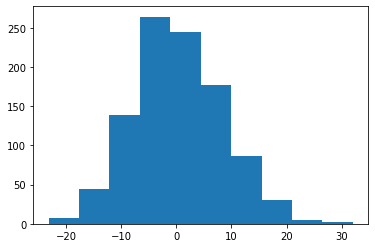

In [49]:
# distribution of values at random spatial point
plt.hist(diffs_DJF[:,10,20]);

In [50]:
lev_1 = 0.025
lev_2 = 0.975

DJF_quantiles = diffs_DJF.quantile([lev_1,lev_2], dim='sample')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


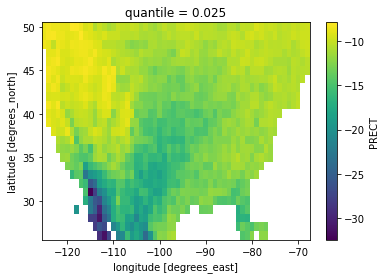

In [51]:
DJF_quantiles.sel(quantile=lev_1).plot();

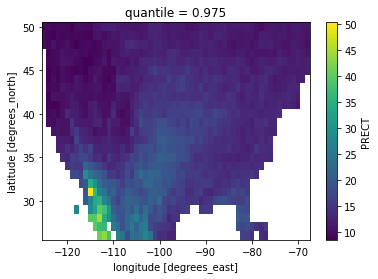

In [52]:
DJF_quantiles.sel(quantile=lev_2).plot();

### MAM

In [53]:
%%time
# NOTE: load the concatenated arrays into memory first

#nsamps = 10
nsamps = 1000

# initialize a difference array
diffs_MAM = xr.zeros_like(PEx_MAM_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_MAM, size=int(totalsize_MAM/2), replace=True)
    # randomly sample the concatenated precip across hist/rcp
    boot_1 = PEx_MAM_concat_compute.isel(time=rand_index).mean(dim='time') 
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_MAM, size=int(totalsize_MAM/2), replace=True)
    boot_2 = PEx_MAM_concat_compute.isel(time=rand_index).mean(dim='time')
    
    # final bootstrap sample is the percent difference between sums of each sample
    diffs_MAM[ind,...] = 100*(boot_1 - boot_2)/boot_2
    
    # test first iteration of loop
    #break

CPU times: user 4min 23s, sys: 3min 29s, total: 7min 52s
Wall time: 10min 53s


In [54]:
MAM_quantiles = diffs_MAM.quantile([lev_1,lev_2], dim='sample')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


### JJA

In [55]:
%%time
# NOTE: load the concatenated arrays into memory first

#nsamps = 10
nsamps = 1000

# initialize a difference array
diffs_JJA = xr.zeros_like(PEx_JJA_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_JJA, size=int(totalsize_JJA/2), replace=True)
    # randomly sample the concatenated precip across hist/rcp
    boot_1 = PEx_JJA_concat_compute.isel(time=rand_index).mean(dim='time') 
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_JJA, size=int(totalsize_JJA/2), replace=True)
    boot_2 = PEx_JJA_concat_compute.isel(time=rand_index).mean(dim='time')
    
    # final bootstrap sample is the percent difference between sums of each sample
    diffs_JJA[ind,...] = 100*(boot_1 - boot_2)/boot_2
    
    # test first iteration of loop
    #break

CPU times: user 4min 20s, sys: 3min 21s, total: 7min 41s
Wall time: 9min 39s


In [56]:
JJA_quantiles = diffs_JJA.quantile([lev_1,lev_2], dim='sample')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


### SON

In [57]:
%%time
# NOTE: load the concatenated arrays into memory first

#nsamps = 10
nsamps = 1000

# initialize a difference array
diffs_SON = xr.zeros_like(PEx_SON_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_SON, size=int(totalsize_SON/2), replace=True)
    # randomly sample the concatenated precip across hist/rcp
    boot_1 = PEx_SON_concat_compute.isel(time=rand_index).mean(dim='time') 
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_SON, size=int(totalsize_SON/2), replace=True)
    boot_2 = PEx_SON_concat_compute.isel(time=rand_index).mean(dim='time')
    
    # final bootstrap sample is the percent difference between sums of each sample
    diffs_SON[ind,...] = 100*(boot_1 - boot_2)/boot_2
    
    # test first iteration of loop
    #break

CPU times: user 4min 21s, sys: 3min 37s, total: 7min 59s
Wall time: 9min 55s


In [58]:
SON_quantiles = diffs_SON.quantile([lev_1,lev_2], dim='sample')

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


## Save out quantile values for plotting in other notebooks

### Concatenate across season for easier plotting

In [59]:
seasonal_quantiles = xr.concat([DJF_quantiles, MAM_quantiles, JJA_quantiles, SON_quantiles], dim='season')
seasonal_quantiles.coords["season"] = ['DJF','MAM','JJA','SON']
seasonal_quantiles

<xarray.DataArray 'PRECT' (season: 4, quantile: 2, lat: 25, lon: 58)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [ -8.55363448,  -8.84402493, -10.22776825, ..., -10.38918797,
           -9.83710806,  -9.74895669],
         [ -8.73108712,  -8.23901727,  -8.12552187, ..., -10.07571281,
           -9.73936751,  -9.80737487],
         [ -8.64328078,  -8.35999932,  -8.60607591, ..., -10.10868234,
           -9.85236572,  -9.73889156]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [ -4.80366804,  -5.7739437 ,  -6.56154576, ...,  -8.68361426,
           -8.70182198,  -8.59490772],
         [ -4.36347119,  -5.07714678,  -4.91170322, ...,  -9.52481583,
           -9.82405169,  -8.79117851],
         [ -4.42921734,  -3.80476916,  -4.10447357, ...,  -7.89982205,
           -8.89961877,  -7.71460561]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [  4.77361078,   5.95895114,   7.55653891, ...,   9.77491892,
            9.57864437,   9.79243742],
         [  4.48980987,   4.97833013,   4.72587853, ...,   9.75486755,
            9.73724881,   9.35953864],
         [  4.37703516,   3.83385983,   4.49451926, ...,   8.7455743 ,
            8.91538618,   7.94926979]]]])
Coordinates:
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * quantile  (quantile) float64 0.025 0.975
  * season    (season) <U3 'DJF' 'MAM' 'JJA' 'SON'

In [60]:
seasonal_quantiles.to_netcdf(postprocessing_filepath+'PEx90_boot_diffs_byseason.nc', mode='w', format='NETCDF4')